In [23]:
#importing matplotlib and styles
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
#import libraries
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [26]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [27]:
# reflect existing database into new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [28]:
# view all classes
Base.classes.keys()

['measurement', 'station']

In [29]:
# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# create session link from python to db
session = Session(engine)

In [31]:
# function to take in start and end date, return min, max, avg temp for the date range
def calc_temps(start_date, end_date):
    """
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# calculate min, max, avg temp for first week of Aug 2017
[(tmin, tavg, tmax)] = calc_temps('2017-08-01', '2017-08-07')
tavg

79.25

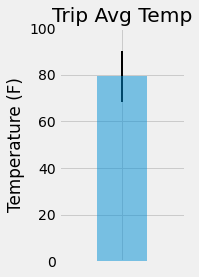

In [33]:
# plot results from previous query as bar chart, avg temp as bar height, tmax-tmin (peak-to-peak) as y-error bar

plt.figure(figsize=(2, 4))
plt.bar(1, tavg, width=0.8, alpha=0.5, zorder=3)
plt.errorbar(1, tavg, yerr=[tmax-tmin], elinewidth=2, ecolor='black')
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.tick_params(bottom=False, labelbottom=False)
plt.xlim(0, 2)
plt.ylim(0, 100)
plt.grid(axis='y', zorder=1)
plt.show()

### Daily Rainfall Average

In [34]:
# creating date objects of the dates desired, for use in querying the tables
start_date = dt.date(2017, 8, 1).strftime('%Y-%m-%d')
end_date = dt.date(2017, 8, 7).strftime('%Y-%m-%d')
start_date, end_date

('2017-08-01', '2017-08-07')

In [35]:
# list station id, station name, total precipitation over the time period (1-8 Aug 17), lat, long, elevation
# sort in descending order by precipitation amount
sel = [Measurement.station, Station.name, func.sum(Measurement.prcp), 
       Station.latitude, Station.longitude, Station.elevation]
for row in session.query(*sel).filter(
    Measurement.station == Station.station, Measurement.date >= start_date, Measurement.date <= end_date
).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()):
    print(f'Station ID: {row[0]}, Station Name: {row[1]}, Total Precipitation: {row[2]}, ' 
          f'Station Latitude: {row[3]}, Station Longitude: {row[4]}, Station Elevation: {row[5]}')
    print('         ')

Station ID: USC00516128, Station Name: MANOA LYON ARBO 785.2, HI US, Total Precipitation: 0.36, Station Latitude: 21.3331, Station Longitude: -157.8025, Station Elevation: 152.4
         
Station ID: USC00514830, Station Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, Total Precipitation: 0.22, Station Latitude: 21.5213, Station Longitude: -157.8374, Station Elevation: 7.0
         
Station ID: USC00519281, Station Name: WAIHEE 837.5, HI US, Total Precipitation: 0.06, Station Latitude: 21.45167, Station Longitude: -157.84888999999998, Station Elevation: 32.9
         
Station ID: USC00519397, Station Name: WAIKIKI 717.2, HI US, Total Precipitation: 0.04, Station Latitude: 21.2716, Station Longitude: -157.8168, Station Elevation: 3.0
         
Station ID: USC00519523, Station Name: WAIMANALO EXPERIMENTAL FARM, HI US, Total Precipitation: 0.0, Station Latitude: 21.33556, Station Longitude: -157.71139, Station Elevation: 19.5
         


In [36]:
# func to calc daily normals (tmin, tmax, tavg) of all data matching a month and day

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for the trip
# create a range of dates covering trip duration, append to date_list
dates = session.query(Measurement.date).filter(Measurement.date >=start_date, Measurement.date <=end_date).group_by(Measurement.date)
date_list = [x[0] for x in dates]
date_list

['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [40]:
# strip years from date_list
date_list_md = [x[5:] for x in date_list]
date_list_md

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [41]:
# apply daily_normals func to each date
# append to list
normals = [daily_normals(x) for x in date_list_md]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [42]:
tmins = [x[0][0] for x in normals]
tavgs = [x[0][1] for x in normals]
tmaxs = [x[0][2] for x in normals]

In [43]:
# load into df (using date_list to see the year in the date), use date as index
normals_df = pd.DataFrame({
    'date': date_list, 'tmin': tmins, 'tavg': tavgs, 'tmax': tmaxs
})
normals_df.set_index('date', inplace=True, drop=True)
normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


Text(0, 0.5, 'Temperature (F)')

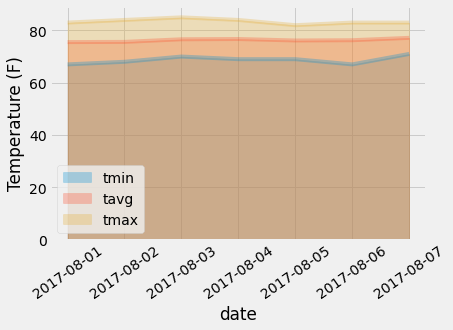

In [44]:
# plot daily normals from df as area plot with stacked=False
normals_df.plot.area(stacked=False, rot=35, alpha=0.3)
plt.ylabel('Temperature (F)')

## Close Session

In [45]:
# Close Session
session.close()